In [171]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
from Utils.DataLoader import DataLoader
from Utils.DataTransformer import DataTransformer
from Utils.DuckDb.DuckDb import DuckDb
from Utils.DatasetProcessor.DatasetProcessorUtils import DatasetProcessorUtils
from datetime import datetime
import pandas as pd
from typing import List
from Utils import PandasNotebookConfigs
import project_config
import numpy as np
import matplotlib.pyplot as plt
import joblib
from datetime import datetime
from Utils.Datetime import DatetimeUtils
from Utils.Dict import DictUtils

In [173]:
PandasNotebookConfigs.config()

Ajustando display.float.format para %.4f


In [174]:
DUCK_DB = DuckDb()
DATA_TRANSFORMER = DataTransformer()
DATA_PROCESSOR_UTILS = DatasetProcessorUtils(DUCK_DB)
DATETIME_UTILS = DatetimeUtils()
DICT_UTILS = DictUtils()

In [175]:
HEAVY_USER_CLUSTER_NAME = 'Heavy User'
CASUAL_USER_CLUSTER_NAME = 'Casual User'
LIGHT_USER_CLUSTER_NAME = 'Light User'

In [176]:
CLUSTERS = [
    # From the heaviest to the lowest
    HEAVY_USER_CLUSTER_NAME,
    CASUAL_USER_CLUSTER_NAME,
    LIGHT_USER_CLUSTER_NAME
]

In [177]:
df = DUCK_DB.load_table(
    project_config.PREDICTED_DATA_TABLE
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [178]:
len(df), len(df['msno'].unique())

(817973, 262270)

In [179]:
# Group by msno and get the last register
df = df.groupby('msno').tail(1)
len(df)

262270

In [180]:
df = df[project_config.COLUMNS_USED_ON_TRAIN_AND_PREDICTION + [project_config.TARGET_COLUMN]]

In [181]:
df.head()

,registration_init_time_day,registration_init_time_day_of_year,registration_init_time_year,transaction_date_day,transaction_date_day_of_week,transaction_date_day_of_year,transaction_date_month,membership_expire_date_day,membership_expire_date_day_of_year,membership_expire_date_month,...,payment_method_id_39,payment_method_id_4,payment_method_id_40,payment_method_id_41,payment_method_id_5,payment_method_id_6,payment_method_id_7,payment_method_id_8,payment_method_id_9,is_churn
3,8,159,2014,15,2,46,2,15,74,3,...,False,False,False,True,False,False,False,False,False,False
6,18,322,2010,31,1,31,1,19,78,3,...,True,False,False,False,False,False,False,False,False,False
10,27,270,2014,26,6,57,2,26,85,3,...,False,False,False,True,False,False,False,False,False,False
14,15,75,2016,15,2,46,2,15,74,3,...,False,False,False,True,False,False,False,False,False,False
17,22,22,2012,31,1,31,1,23,82,3,...,True,False,False,False,False,False,False,False,False,False


In [182]:
test_df = df[:10_000].copy()

In [183]:
usage_columns = [
 'num_100', 'num_100-1M', 'num_100-2M',
 'num_25', 'num_25-1M', 'num_25-2M',
 'num_50', 'num_50-1M', 'num_50-2M',
 'num_75', 'num_75-1M', 'num_75-2M',
 'num_985', 'num_985-1M', 'num_985-2M',
 'num_unq', 'num_unq-1M', 'num_unq-2M',
 'total_secs', 'total_secs-1M', 'total_secs-2M',
 'is_churn',
]
usage_df = test_df[usage_columns]

In [184]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=len(CLUSTERS), random_state=42)
customer_clusters = kmeans.fit_predict(usage_df)

In [185]:
# Assign cluster labels to the DataFrame
usage_df['cluster'] = kmeans.labels_

# View centroids (cluster centers)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=usage_df.columns[:-1])  # Exclude the cluster column
print("Cluster Centroids:")
print(centroids)

Cluster Centroids:
    num_100  num_100-1M  num_100-2M   num_25  num_25-1M  num_25-2M  num_50  \
0  616.4547    696.3744    695.7332 142.0866   172.0155   176.5022 34.7550   
1  136.9162    156.0548    153.2747  47.1314    54.3452    54.5487 11.3318   
2 1509.9508   1618.1203   1601.2898 212.3571   242.2018   242.6223 53.1358   

   num_50-1M  num_50-2M  num_75  ...  num_985  num_985-1M  num_985-2M  \
0    41.2517    42.2299 22.6621  ...  25.1750     29.4237     29.7240   
1    12.9770    13.0484  6.7516  ...   7.1767      8.2595      8.1132   
2    58.6184    58.5097 34.8616  ...  42.6171     46.7232     47.7025   

    num_unq  num_unq-1M  num_unq-2M  total_secs  total_secs-1M  total_secs-2M  \
0  629.2461    719.6673    724.4727 163304.0380    185244.6238    185670.2067   
1  161.8735    185.2320    184.8627  37238.0679     42599.1588     42017.2587   
2 1278.5201   1385.2329   1377.4334 389127.3131    417228.9599    415088.0427   

   is_churn  
0    0.0361  
1    0.1494  
2    0.0

/tmp/ipykernel_5609/2243360524.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usage_df['cluster'] = kmeans.labels_


In [186]:
import numpy as np

# Compute the standard deviation of each feature across clusters
feature_importance = centroids.std(axis=0).sort_values(ascending=False)

# Get the top 10 features
top_10_features = feature_importance.head(10)
print("Top 10 Features Differentiating the Clusters:")
print(top_10_features)


Top 10 Features Differentiating the Clusters:
total_secs-1M   189081.9702
total_secs-2M   188171.2530
total_secs      178285.7357
num_100-1M         739.2785
num_100-2M         731.5556
num_100            696.8401
num_unq-1M         601.1934
num_unq-2M         597.1825
num_unq            560.7872
num_25-2M           95.4080
dtype: float64


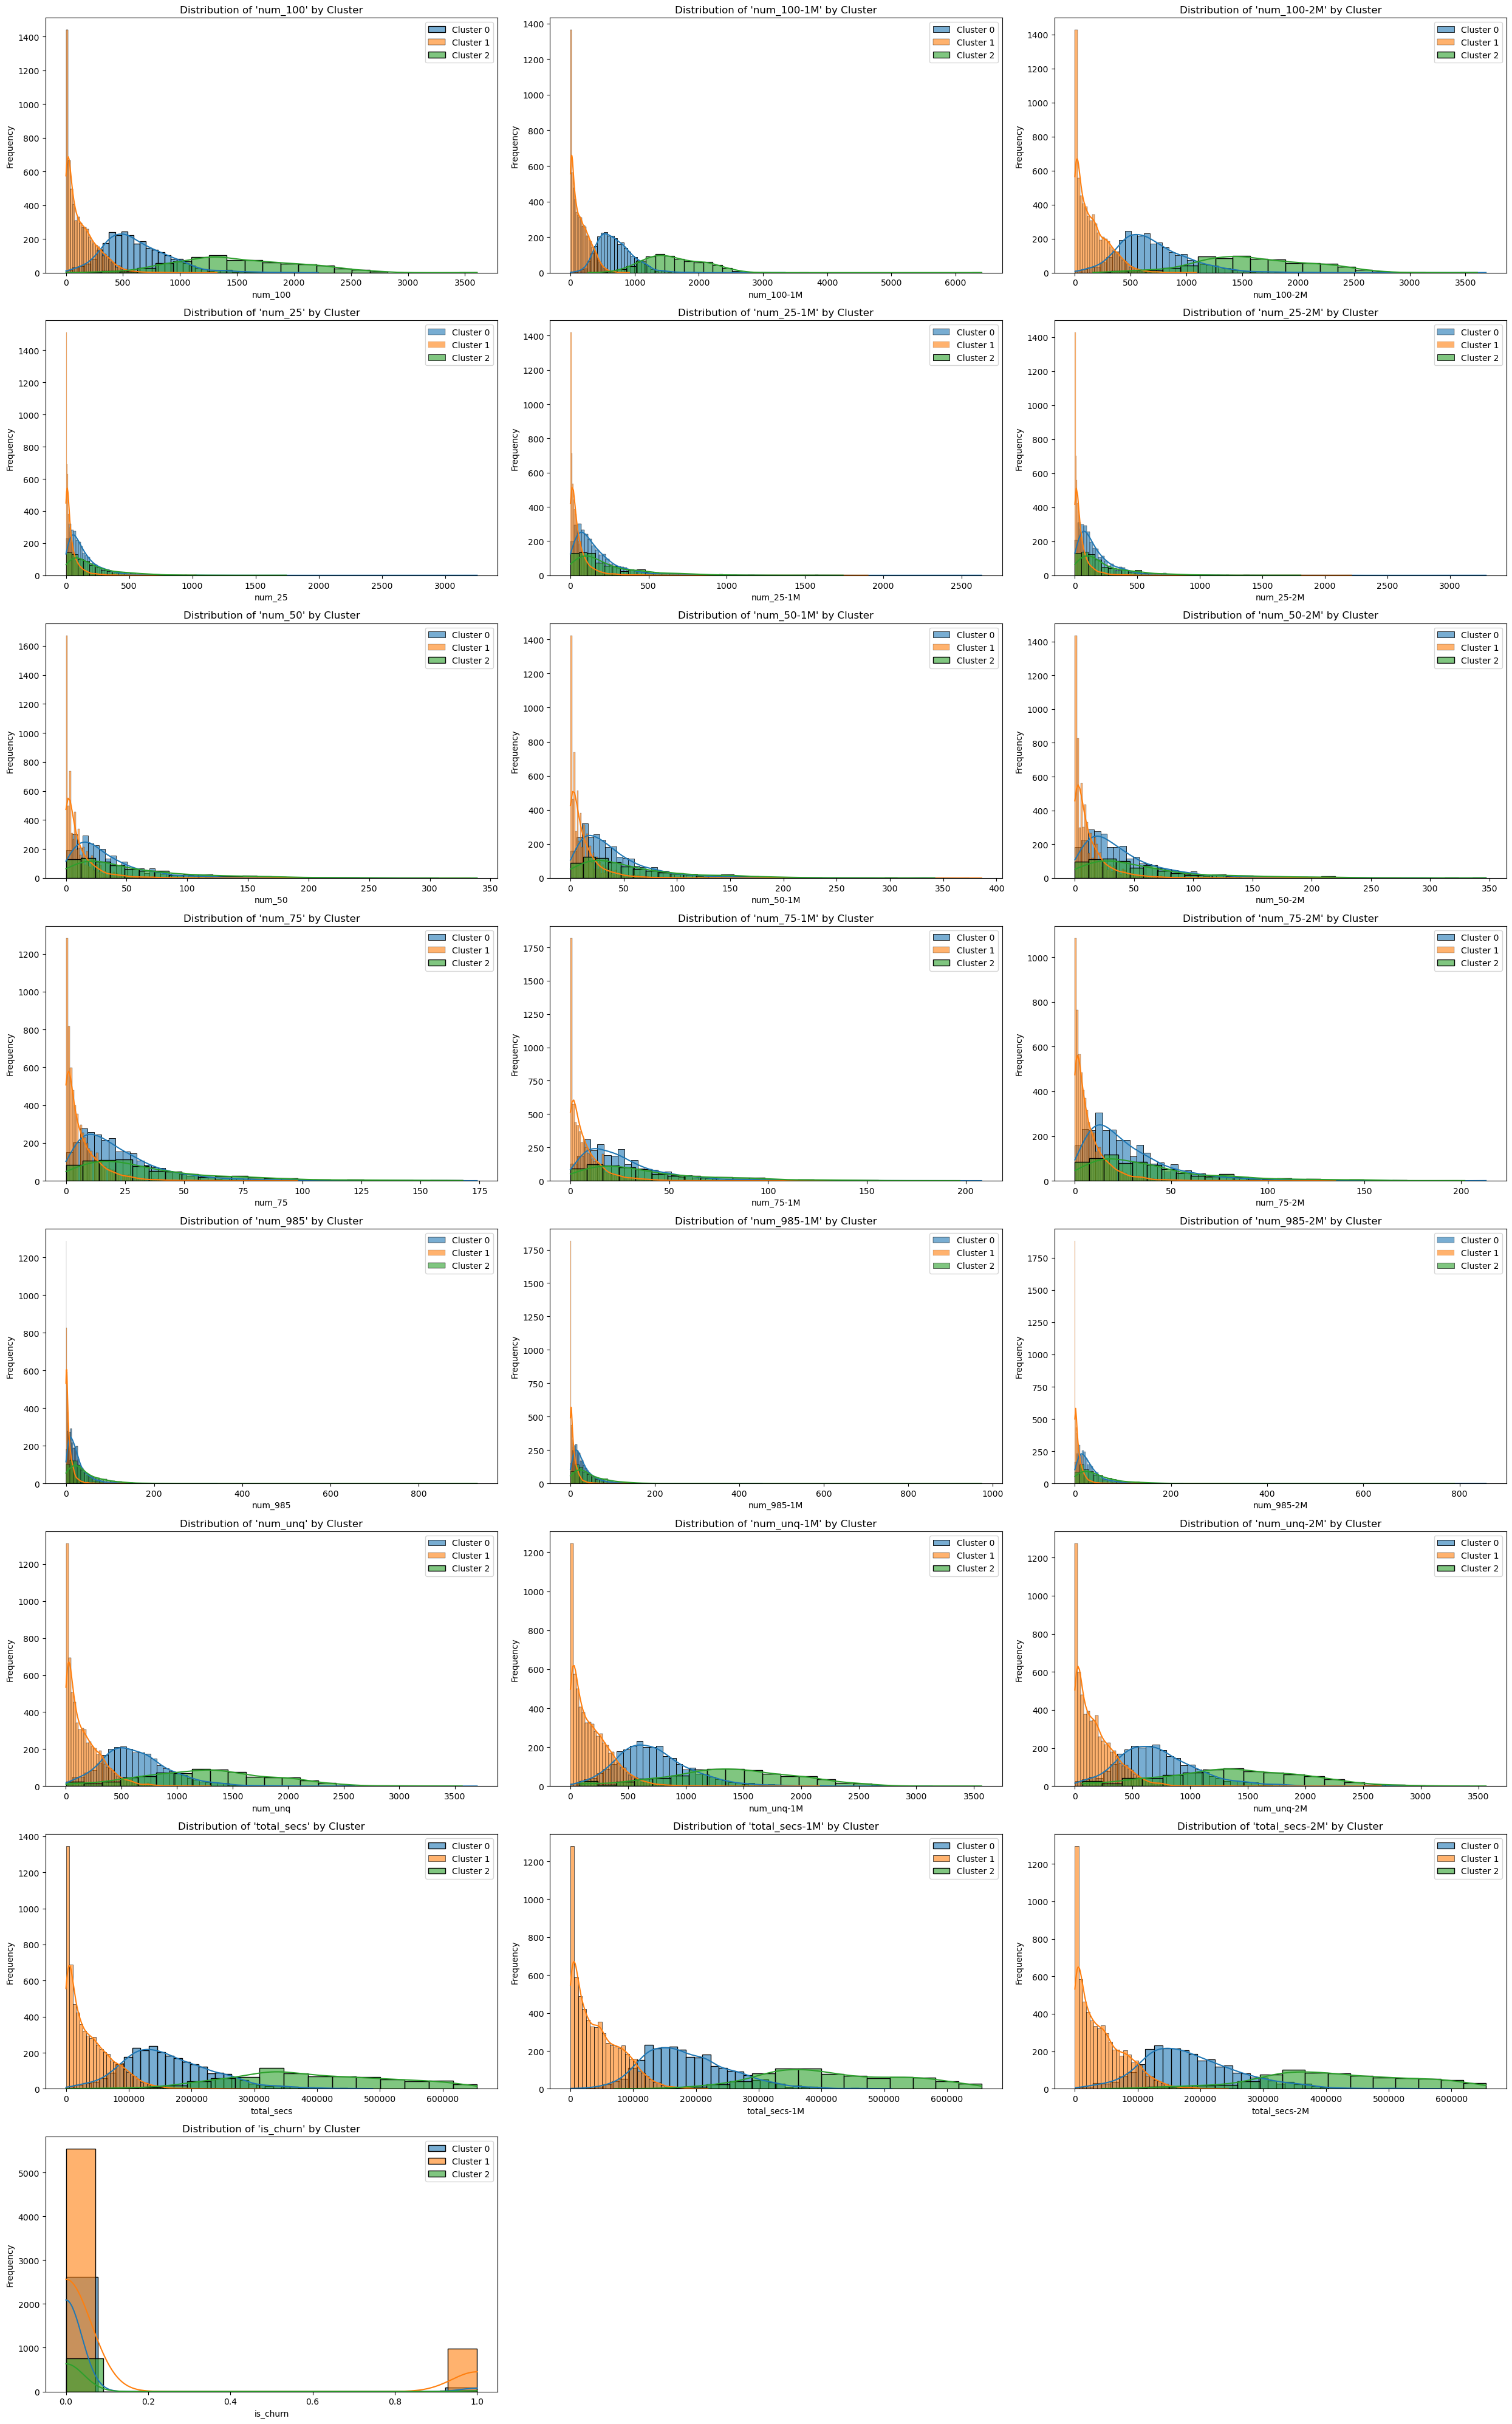

In [187]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Extract features (excluding 'cluster') and define the number of rows/columns
features = usage_df.drop('cluster', axis=1).columns
n_features = len(features)
n_cols = 3  # Number of figures per row
n_rows = math.ceil(n_features / n_cols)  # Calculate the number of rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, n_rows * 5))  # Adjust the figure size
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Iterate through each feature and create a histogram
for i, feature in enumerate(features):
    ax = axes[i]
    for cluster_id in usage_df['cluster'].unique():
        sns.histplot(
            data=usage_df[usage_df['cluster'] == cluster_id],
            x=feature,
            kde=True,
            label=f'Cluster {cluster_id}',
            alpha=0.6,
            ax=ax  # Specify the subplot for this feature
        )
    ax.set_title(f"Distribution of '{feature}' by Cluster")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frequency")
    ax.legend()

# Hide unused subplots if the number of features is not a multiple of n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [303]:
def get_usage_info_form_clusters(df: pd.DataFrame):
    cols = [
        'total_secs',
        'num_unq'
    ]

    cluster_values_map = get_cluster_value_map(df)

    for cluster in cluster_values_map:
        grp = df[df['cluster'] == cluster]
        print(f'Cluster {cluster_values_map[cluster]}')

        for col in cols:
            print(f'\t-> Mediana de {col}: {grp[col].median()}')
            # print(f'\t-> Média de {col}: {grp[col].mean()}')
            # print()

        print()
        # print(grp)


get_usage_info_form_clusters(usage_df)

Cluster Heavy User
	-> Mediana de total_secs: 377088.0
	-> Mediana de num_unq: 1257.0

Cluster Casual User
	-> Mediana de total_secs: 152871.0
	-> Mediana de num_unq: 589.5

Cluster Light User
	-> Mediana de total_secs: 26388.0
	-> Mediana de num_unq: 110.0



In [ ]:
usage_df.groupby('cluster').value_counts().plot.bar()

KeyboardInterrupt: 

In [302]:
from typing import Dict


def get_cluster_value_map(df: pd.DataFrame) -> Dict[str, any]:
    field_to_consider = 'total_secs'

    # Order clusters by total_secs mean value
    cluster_mean_total_secs = {}
    for i in range(0, len(CLUSTERS)):
        cluster_df = df[df['cluster'] == i]
        cluster_mean_total_secs[i] = cluster_df[field_to_consider].mean()

    cluster_mean_total_secs = DICT_UTILS.sort_dict_by_values(cluster_mean_total_secs)

    cluster_names = {}
    sorted_clusters_keys = list(cluster_mean_total_secs.keys())
    sorted_clusters_keys.reverse()
    for index, key in enumerate(sorted_clusters_keys):
        # print(f'Cluster {key} = {CLUSTERS[index]}')
        cluster_names[key] = CLUSTERS[index]

    return cluster_names

In [189]:
# Giving names to clusters
def name_clusters(df: pd.DataFrame) -> pd.DataFrame:
    cluster_names = get_cluster_value_map(df)

    # Filling out the cluster_named column
    col_data = []
    for _, row in usage_df.iterrows():
        row_cluster = row['cluster']

        col_data.append(cluster_names[row_cluster])

    df['cluster_named'] = col_data
    return df

In [190]:
usage_df = name_clusters(usage_df)

Cluster 2 = Heavy User
Cluster 0 = Casual User
Cluster 1 = Light User


/tmp/ipykernel_5609/3569267362.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_named'] = col_data


In [191]:
usage_df.head(20)

,num_100,num_100-1M,num_100-2M,num_25,num_25-1M,num_25-2M,num_50,num_50-1M,num_50-2M,num_75,...,num_985-2M,num_unq,num_unq-1M,num_unq-2M,total_secs,total_secs-1M,total_secs-2M,is_churn,cluster,cluster_named
3,468,438.0000,855.0000,116,135.0000,193.0000,61,69.0000,88.0000,58,...,142.0000,642,696.0000,979.0000,156533,157868.0000,256812.0000,False,0,Casual User
6,715,533.0000,520.0000,108,43.0000,59.0000,36,25.0000,23.0000,30,...,21.0000,840,676.0000,545.0000,198105,154978.0000,133337.0000,False,0,Casual User
10,383,651.0000,579.0000,188,289.0000,166.0000,80,175.0000,73.0000,46,...,43.0000,551,1088.0000,645.0000,123768,215757.0000,169086.0000,False,0,Casual User
14,258,384.0000,483.0000,103,54.0000,86.0000,47,9.0000,24.0000,27,...,23.0000,194,130.0000,342.0000,78863,106043.0000,132765.0000,False,1,Light User
17,176,190.0000,91.0000,88,58.0000,49.0000,19,24.0000,11.0000,14,...,18.0000,304,270.0000,165.0000,51758,54255.0000,29430.0000,False,1,Light User
19,183,183.0000,183.0000,14,14.0000,14.0000,1,1.0000,1.0000,5,...,0.0000,140,140.0000,140.0000,43731,43731.0000,43731.0000,False,1,Light User
23,22,87.0000,94.0000,4,9.0000,82.0000,4,7.0000,44.0000,4,...,21.0000,28,95.0000,207.0000,5712,22640.0000,33137.0000,False,1,Light User
24,24,24.0000,24.0000,6,6.0000,6.0000,1,1.0000,1.0000,1,...,0.0000,20,20.0000,20.0000,6352,6352.0000,6352.0000,True,1,Light User
26,86,86.0000,86.0000,21,21.0000,21.0000,8,8.0000,8.0000,1,...,2.0000,115,115.0000,115.0000,23387,23387.0000,23387.0000,False,1,Light User
27,1,1.0000,1.0000,0,0.0000,0.0000,0,0.0000,0.0000,0,...,0.0000,1,1.0000,1.0000,392,392.0000,392.0000,True,1,Light User


In [263]:
from typing import List


def plot_pizza(
    value_counts: pd.DataFrame, labels: List[str], title: str, legend: str, ax: plt = None,
    colors: List[str] = None
):
    if ax is None:
        fig, ax = plt.subplots()

    ax.pie(
        value_counts,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'edgecolor': 'black'},
        colors=colors,
        # frame=ax,
    )

    ax.set_title(title)

    ax.legend(
        labels,
        title=legend,
        bbox_to_anchor=(1.0, 1),
    )

Cluster 2 = Heavy User
Cluster 0 = Casual User
Cluster 1 = Light User


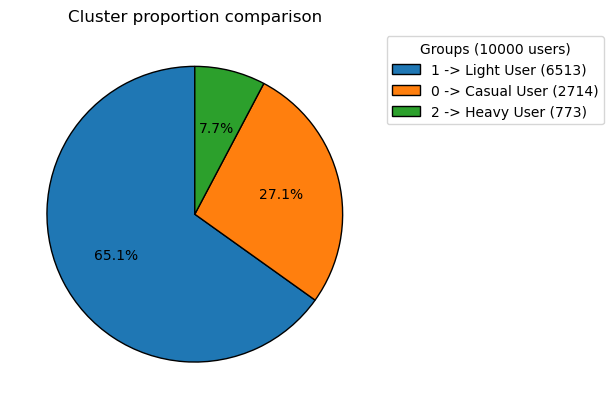

In [264]:
def compare_cluster_proportion(df: pd.DataFrame):
    cluster_value_map = get_cluster_value_map(df)

    counted = df['cluster'].value_counts()
    labels = []
    for i in counted.index:
        labels.append(
            f'{i} -> {cluster_value_map[i]} ({counted[i]})'
        )

    plot_pizza(
        value_counts=counted,
        labels=labels,
        title='Cluster proportion comparison',
        legend=f'Groups ({len(df)} users)'
    )

compare_cluster_proportion(usage_df)

Cluster 2 = Heavy User
Cluster 0 = Casual User
Cluster 1 = Light User


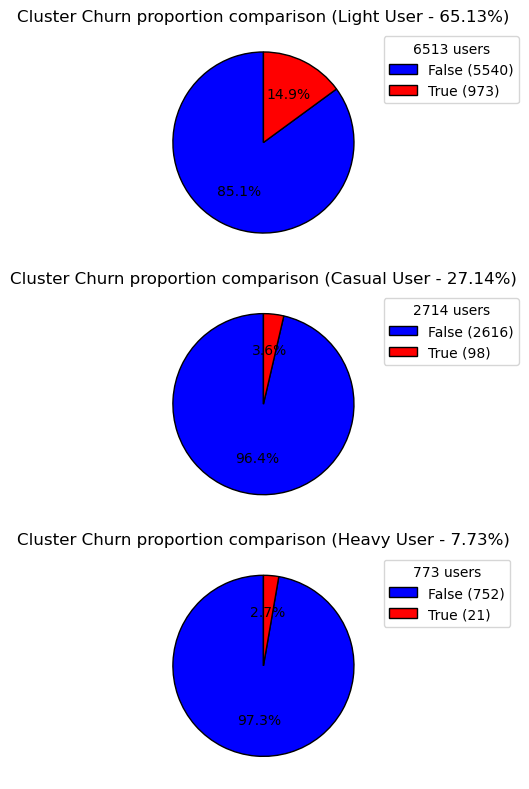

In [270]:
def compare_cluster_is_churn_proportion(df: pd.DataFrame):
    cluster_value_map = get_cluster_value_map(df)

    n_rows = 3
    n_cols = 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 8))  # Adjust the figure size
    axes = axes.flatten()  # Flatten the axes array for easier indexing

    cluster_counted = df['cluster'].value_counts()
    for index, cluster in enumerate(cluster_counted.index):
        filtered_df =  df[df['cluster'] == cluster]
        is_churn_counted = filtered_df['is_churn'].value_counts()

        cluster_percentage = len(filtered_df) * 100 / len(df)

        plot_pizza(
            value_counts=is_churn_counted,
            labels=[f'{x} ({is_churn_counted[x]})' for x in is_churn_counted.index],
            title=f'Cluster Churn proportion comparison ({cluster_value_map[cluster]} - {cluster_percentage}%)',
            legend=f'{len(filtered_df)} users',
            ax=axes[index],
            colors=['blue', 'red']
        )

    plt.tight_layout()
    plt.show()

compare_cluster_is_churn_proportion(usage_df)

# Conclusão
Podemos perceber 3 tipos de usuários:
- Usuários Light (usam menos a plataforma; são a grande maioria)
- Usuários Casuais (utilizam de forma moderada; cerca de 1/4 dos usuários)
- Usuários Pesados (utilizam de forma intensa)

Quanto mais os usuários utilizam a plataforma, menos eles tendem a virar churn no futuro.